## TODO

1. Create decision plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob

pd.set_option("display.max_rows", 50)
# pd.set_option('display.max_colwidth', -1)
%matplotlib inline

def curve_fit(x, y, smoothness=.5):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    results = lowess(y, x, is_sorted=True, frac=smoothness)
    return results[:, 1]

# 4th Down Bot

The NYT 4th Down Bot uses NFL play-by-play data to make a recommendation for 4th down decisions.  The current model behind the 4th Down Bot estimates the win probability given a state of the game.  We will do a recreation of the original 4th Down Bot model from Brian Burke (now of ESPN, formerly of Advanced Football Analytics).

The basic premise of the model is to maximize the expected value of the 4th down decision. To do this, we will use NFL play-by-play data to estimate quantities related to the value of a location on the field, punt distance, likelihood of converting a first down, and likelihood of making a field goal.  This notebook builds a replica of the bot.

+ The NYT 4th Down Bot can be found here: http://nyt4thdownbot.com/ 
+ The model: http://www.advancedfootballanalytics.com/index.php/home/research/game-strategy/120-4th-down-study
+ Coverage: http://www.nytimes.com/newsgraphics/2013/11/28/fourth-downs/post.html
+ More coverage: https://www.nytimes.com/2015/10/02/upshot/a-better-4th-down-bot-giving-analysis-before-the-play.html
+ Slides on the construction of the new model: http://slides.com/treycausey/4thdownbot#/
+ The new model on GitHub: https://github.com/TheUpshot/4thdownbot-model
+ Berkeley's own David Romer on 4th down decisions: https://eml.berkeley.edu/~dromer/papers/JPE_April06.pdf

## I. The Model

Our goal will be to maximize the expected value of the decision to go for it, punt, or kick a field goal.  This means we need to compute the following quantities:

 + Expected Possession Value (EPV): the value, in points, of a first down at any location on the field.  Kickoffs will also require an expected value.
 + Probability of making a 4th down conversion given a location on the field, eg. how likely a team is to make a 4th and 3 conversion from the opponent 47 yard line.  We can use this with EPV to quantify the expected value of going for the first down.
 + Expected net punt distance given a location on the field.  Coupled with EPV, this quantifies the expected value of punting.
 + Probability of making a field goal from a given distance, eg. how likely it is to make a 45 yard field goal.  Combined with the EPV for field location and kickoffs, we can compute an expected value of kicking the field goal by estimating the likelihood and expected value of a miss or a make.
 
These 4 quantities can be combined to produce expected value of going for the first down, punting, or kicking the field goal.  Our decision rule will be to choose the option that maximizes expected value.  The model we will build is a baseline "average" model that can be used as a starting point before factoring in issues like quality of field goal kicker, offense or defense quality, or weather.

More details on the individual computations for the three expected value quantities is below.

## II. NFL PxP Data

NFL play-by-play data is loaded from csv format.  

Below is a list of avaible columns we will use.  Many are self explanatory so when needed, a description will be given.  Note, there are many more fields available that we will not use.
+ GameID
+ Drive - index given the # of the drive within the game
+ qtr
+ down
+ yrdline100 - the yard line expressed on a scale of 1 to 99 instead of 1 to 50 and back to 1.
+ ydstogo - yards to go for a first down
+ Yards.Gained - yards gained on the play
+ posteam - possessing team
+ DefensiveTeam - defensive team
+ desc - play description
+ PlayType - label for what type of play
+ Touchdown - 0,1 indicating if a TD was scored
+ FieldGoalResult - label indicating good, blocked, or no good.
+ FieldGoalDistance
+ PosTeamScore - Score of the possessing team.  This will flip when the possession flips.
+ DefTeamScore - Score of the defensive team.  This will flip when the possession flips.
+ HomeTeam
+ AwayTeam


A few convenient data fields are added to easy computation of possession value.

+ half
+ yrdregion - region of the field: Inside the 10, 10 to 20, and beyond 20.
+ HomeScore & AwayScore - The score of the possession and defensive teams are given.  This changes as the ball changes possession
+ nextposteam - The team possessing the ball in the next play. Non-plays are ignored
+ nextyrdline100 - Where the ball is on the next play. Non-plays are ignored
+ nextdown - The down for the next play
+ 1stdownconversion - Whether the current play converted a first down (0 or 1 value)

# NCAA data

In [2]:
def load_year(pxp):
#missing 'FieldGoalResult' and 'FieldGoalDistance', already have 'homeScore' and 'awayScore'
#FieldGoalresults is either Good, No Good or Blocked

# College Quarters: 1,2,3,4,5,6
# down is 1,2,3,4,0. change 0 to 'nan'
# why is distance negative???
# distance: all goal line is (0)
# playtypes: 'Kickoff', 'Rush', 'Pass Incompletion', 'Passing Touchdown',
#        'Kickoff Return (Offense)', 'Penalty', 'Punt', 'Pass Reception',
#        'Rushing Touchdown', 'End Period', 'Fumble Recovery (Own)', 'Sack',
#        'Timeout', 'Field Goal Good', 'End of Half',
#        'Fumble Recovery (Opponent)', 'Pass Interception Return',
#        'End of Game', 'Blocked Punt', 'Field Goal Missed',
#        'Interception Return Touchdown', 'Fumble Return Touchdown',
#        'Safety', 'Blocked Field Goal', 'Kickoff Return Touchdown',
#        'Blocked Field Goal Touchdown', 'Missed Field Goal Return',
#        'Punt Return Touchdown', nan, 'Defensive 2pt Conversion'
# for NFL, types: 'Kickoff', 'Pass', 'Run', 'Timeout', 'Extra Point', 'Sack',
#        'Quarter End', 'Punt', 'No Play', 'Two Minute Warning', 'Spike',
#        'Field Goal', 'QB Kneel', 'End of Game', 'Half End'
# isScoringPlay types: 'Passing Touchdown', 'Rushing Touchdown', 'Field Goal Good',
#        'Interception Return Touchdown', 'Fumble Return Touchdown',
#        'Safety', 'Kickoff Return Touchdown', 'Punt',
#        'Blocked Field Goal Touchdown', 'Blocked Punt',
#        'Punt Return Touchdown', 'Fumble Recovery (Opponent)',
#        'Kickoff Return (Offense)', nan, 'Kickoff',
#        'Defensive 2pt Conversion'

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
                                (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
                               [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan').astype(int)
    
    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown'), 1, 0)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
    fgcondition = [(pxp['type']=='Field Goal Good'), 
                (pxp['type']=='Field Goal Missed'),
                (pxp['type']=='Missed Field Goal Return'),
                (pxp['type']=='Missed Field Goal Return Touchdown'),
                (pxp['type']=='Blocked Field Goal'),
                (pxp['type']=='Blocked Field Goal Touchdown')]
    pxp['FieldGoalResult'] = np.select(fgcondition, ['Good', 'No Good', 'No Good', 'No Good', 'Blocked', 'Blocked'])
    pxp['FieldGoalResult'] = pxp['FieldGoalResult'].replace('0', np.nan)
    
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)
    pxp.loc[(pxp['type'].isin(['Field Goal Good','Field Goal Missed','Blocked Field Goal'])),'FieldGoalDistance']=pxp['yardsGained']
    pxp.loc[(pxp['type'].isin(['Missed Field Goal Return', 'Missed Field Goal Return Touchdown','Blocked Field Goal Touchdown'])),'FieldGoalDistance']=pxp['yrdline100'].astype(int)+17


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    pxp.loc[ignore_mask, '1stdownconversion4'] = (
        (pxp.loc[ignore_mask, 'nextposteam'] == pxp.loc[ignore_mask, 'offenseTeam'])
    ).astype(int)
    
    return pxp

### Extract Kickoffs and Possession Starts

We need to extract kickoffs and possession starts in order to build a possession value calculator.  To do that, we follow this process:
1. Isolate kickoffs by using PlayType. 
2. Drill down by GameID and Drive # (ignoring kickoffs) and take the first play of the drive.  We need to ignore kickoffs and extra points because those can both appear as the first play of a drive.  This will pollute our results if we do not ignore them.
3. Find the next score in the game for each possession.  This is the hardest computation.  We do this by computing differences in the home and away scores and then fill those backward.  We treat home scores as positive and away scores as negative.  We only consider possession value within a half.  So if there is no score before halftime or the end of the game, the value is 0.
4. Compute possession value.  We multiply the next score value by +1 or -1 depending on if the current possessing team is the home team or away team.  If its the home team, then multiply by +1 because the next score is already oriented to the home team.  If its the away team, then multiply by -1 because a positive next score is a negative for the away team.
5. Restrict possessions to the first and third quarter to avoid end of half/game effects like settling for points at the end of the first half or playing to win at the end of the game.

Some caveats:
+ The dataset used is not perfect so while we expect this procedure to work a vast majority of the time, it may miss some results because of holes in the dataset.  It is unlikely this affects the analysis too much.
+ While we restricted to first and third quarters, we did not restrict cases when there is a blowout.  Competitive games lead to more reliable results so this is probably the first issue to address going forward.

In [3]:
def extract_kickoffs_and_possessions(pxp):
    
    ko_mask = pxp['type'].isin(['Kickoff', 'Kickoff Return (Defense)','Kickoff Return Touchdown','Kickoff Return (Offense)'])  
    kickoffs = pxp.loc[ko_mask]
    # Exclude kickoffs and XPs and groupby GameID and Drive
    xp_mask = pxp['type'].isin(['Extra Point Good','Blocked PAT','Extra Point Missed','No Play'])
    game_drives = pxp.loc[~ko_mask & ~xp_mask].groupby(['gameId', 'driveIndex'])

    poss_starts = game_drives.head(1)

    # Concatenate kickoffs and first plays, sort, and reindex
    ko_and_poss = pd.concat([kickoffs, poss_starts])\
            .sort_values(['gameId', 'driveIndex', 'down'], na_position='first')
    ko_and_poss.reset_index(drop=True, inplace=True)

    # Extract game halves
    game_halves = ko_and_poss.groupby(['gameId', 'half'])
    # Compute changes in the scores.  + for Home and - for Away. Aka if the away team score then -7
    score_change = -game_halves['homeScore'].diff(-1) + game_halves['awayScore'].diff(-1)
    # Backfill the score change so that each possession now has a value for next score in the game (when does the next score come)
    ko_and_poss['NextScore'] = score_change.replace(to_replace=0., method='bfill').fillna(0)

    # Determine if the possessing team is home or away
    posteam = ko_and_poss['offenseTeam']
    hometeam = ko_and_poss['homeTeam']
    awayteam = ko_and_poss['awayTeam']
    posteam_is_home = (posteam == hometeam).astype(int)
    posteam_is_away = (posteam == awayteam).astype(int)
    # NextScore is unchanged if posteam == hometeam and negated if posteam == awayteam
    ko_and_poss['PossessionValue'] = ko_and_poss['NextScore'] * \
        (posteam_is_home - posteam_is_away)

    return ko_and_poss

### Extract Punts

We need to extract net punt distance.  Extracing punts is easy.  Determining net punt distance is tricky.  A few things can happen on a punt: it goes off as expected; returned for a touchdown; muffed; fumbled; blocked.  There may be even more wrinkles.  Suffice to say, this is a bit complicated.  To simplify things, we just want to know the expected net punt distance for punts that are not returned, muffed, fumbled, blocked, or anything else.  

Why is it okay to simplify things?  Those complicating events do not happen often enough to materially affect the computation and just add a nuisance to the whole model.  Consider a return TD worth about 7 points.  If a return TD happens every 100 punts, then its worth about 0.01 points in expectation.  Not really a huge amount.

We compute net punt distance by finding regular punts and determining the field position change.

In [4]:
def extract_punts(pxp):
    # Build table of punts
    punt_mask = pxp['type'].isin(['Punt', 'Blocked Punt', 'Punt Return'])
    punts = pxp.loc[punt_mask].copy()
    punts.reset_index(drop=True, inplace=True)

    # Extract relevant values
    posteam = punts['offenseTeam']
    nextposteam = punts['nextposteam']
    yrdline = punts['yrdline100']
    nextyardline = punts['nextyrdline100'] 

    # Determine if there was a possession change, ie. the punt went off as expected.
    # This excludes muffs or fumbled returns.  It also exludes return TDs and probably
    # some other cases.  It is likely not too bad to do this since these events are rare.
    poss_change = (posteam != nextposteam)
    # Determine the net punt distance
    net_punt_dist = (yrdline.astype(int) - (100 - nextyardline.astype(int))) * poss_change.astype(int)
    # Add net punt length to punts table
    punts.loc[poss_change, 'net_punt_dist'] = net_punt_dist[poss_change]
    
    return punts

### Extract Field Goals

For field goal results, we just need FieldGoalDistance and FieldGoalResult and then to compute a 0-1 value representing the success.  This is straightforward.

When it comes to making 4th down decisions, the quality of the kicker and the field/weather conditions should definitely be taken into consideration.  Remember, we are computing a baseline "average" model that can be used as a starting point.

In [5]:
#def extract_fgs(pxp):
#    fg_mask = pxp['type'].isin(['Field Goal Good','Field Goal Missed','Blocked Field Goal','Blocked Field Goal Touchdown',
#                           'Missed Field Goal Return','Missed Field Goal Return Touchdown'])
#    fgs = pxp.loc[fg_mask, ['FieldGoalDistance', 'FieldGoalResult']].copy()
#    fgs['FieldGoalSuccess'] = (fgs['FieldGoalResult'] == 'Good').astype(int)
#    return fgs

### Extract Third Downs

First, why third downs?  Since most teams do not go for it on fourth down, we need a proxy for the likelihood of converting the first down.  Since third downs are generally considered make-or-break, we opt to substitute performance on third downs for fourth down.

In the dataset, various non-relevant plays can occur on third down.  We need to ignore these.  Also, we can likely safely assume that beyond 9 yards we do not need to consider going for it.

In [6]:
def extract_third_downs(pxp):
    ignore_plays = ['Penalty', 'Timeout', 'End Period', 'Punt Return', 'No Play',
                   'Blocked Punt','Blocked Field Goal', 'Blocked Punt Touchdown', 'Punt',
                   'Field Goal Good', 'Field Goal Missed','Kickoff Return Touchdown',
                   'Kickoff Return (Offense)', 'Missed Field Goal Return',
                   'Defensive 2pt Conversion', 'Kickoff']
    ignore_plays_mask3 = pxp['type'].isin(ignore_plays)
    all_third_downs_mask = (pxp['down'] == 3)
    under_10_to_go3 = ((pxp['distance'] <= 9)&(pxp['distance'] >=0))
    third_down_mask = all_third_downs_mask & ~ignore_plays_mask3 & under_10_to_go3

    third_down_plays = pxp.loc[third_down_mask].\
        copy().\
        reset_index(drop=True)
    return third_down_plays

In [7]:
def extract_fourth_downs(pxp):
    ignore_plays = ['Penalty', 'Timeout', 'End Period', 'Punt Return', 'No Play',
                   'Blocked Punt','Blocked Field Goal', 'Blocked Punt Touchdown', 'Punt',
                   'Field Goal Good', 'Field Goal Missed','Kickoff Return Touchdown',
                   'Kickoff Return (Offense)', 'Missed Field Goal Return',
                   'Defensive 2pt Conversion', 'Kickoff', 'Field Goal','Timeout']
    ignore_plays_mask4 = pxp['type'].isin(ignore_plays)
    all_fourth_downs_mask = (pxp['down'] == 4)
    under_10_to_go4 = ((pxp['distance'] <= 9)&(pxp['distance'] >=0))
    fourth_down_mask = all_fourth_downs_mask & ~ignore_plays_mask4 & under_10_to_go4

    fourth_down_plays = pxp.loc[fourth_down_mask].\
        copy().\
        reset_index(drop=True)
    return fourth_down_plays

### Load Available Data

Load in data for each available year and concatenate each table.

In [8]:
temp = []
data = []
subpxp = []
for year in range(2001,2018):    
    path ='C:/Users/Charlie/Cal Football/ImprovedNCAAFootballData/{}PXP/'.format(year) # use your path
    allFiles = glob.glob(path + "*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
    subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
data= pd.concat(temp, ignore_index=True)

pxp = []
ko_and_poss = []
punts = []
fgs = []
third_downs = []
fourth_downs = []

pxp = load_year(data)
pxp['yrdline100'] = pxp['yrdline100'].astype(int)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
## Extracting possession and kickoffs (starting points)
ko_and_poss = extract_kickoffs_and_possessions(pxp.loc[badyard])
# Retrict to first and third quarters
first_and_third_qtr = (ko_and_poss['quarter'] == 1) | (ko_and_poss['quarter'] == 3)
ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]

punts = extract_punts(pxp)

#fgs = extract_fgs(pxp)

third_downs = extract_third_downs(pxp)

fourth_downs = extract_fourth_downs(pxp)



In [9]:
fourth_downs.head(n=70)

,gameId,year,week,homeTeam,awayTeam,driveIndex,offenseTeam,defenseTeam,homeScore,awayScore,...,yrdline100,yrdregion,Touchdown,FieldGoalResult,FieldGoalDistance,nextposteam,nextyrdline100,nextdown,1stdownconversion,1stdownconversion4
0,213520036,2001,Bowl,Colorado State,North Texas,17,North Texas,Colorado State,24,7,...,40,Beyond20,0,NaN,NaN,Colorado State,49.0,1.0,1.0,0.0
1,213520036,2001,Bowl,Colorado State,North Texas,39,Colorado State,North Texas,45,20,...,52,Beyond20,0,NaN,NaN,North Texas,67.0,1.0,1.0,0.0
2,213530276,2001,Bowl,Marshall,East Carolina,17,Marshall,East Carolina,6,24,...,65,Beyond20,0,NaN,NaN,Marshall,100.0,1.0,1.0,1.0
3,213530276,2001,Bowl,Marshall,East Carolina,24,Marshall,East Carolina,8,38,...,84,Beyond20,0,NaN,NaN,East Carolina,89.0,1.0,1.0,0.0
4,213540152,2001,Bowl,NC State,Pitt,33,NC State,Pitt,19,34,...,75,Beyond20,0,NaN,NaN,NC State,75.0,2.0,0.0,1.0
5,213540152,2001,Bowl,NC State,Pitt,34,NC State,Pitt,19,34,...,78,Beyond20,0,NaN,NaN,Pitt,77.0,1.0,1.0,0.0
6,213610024,2001,Bowl,Stanford,Georgia Tech,1,Stanford,Georgia Tech,0,0,...,98,Beyond20,0,NaN,NaN,Georgia Tech,2.0,1.0,1.0,0.0
7,213610024,2001,Bowl,Stanford,Georgia Tech,9,Georgia Tech,Stanford,3,14,...,8,Inside10,0,NaN,NaN,Georgia Tech,3.0,1.0,1.0,1.0
8,213610024,2001,Bowl,Stanford,Georgia Tech,15,Georgia Tech,Stanford,3,17,...,39,Beyond20,0,NaN,NaN,Stanford,62.0,1.0,1.0,0.0
9,213610024,2001,Bowl,Stanford,Georgia Tech,21,Stanford,Georgia Tech,12,17,...,96,Beyond20,0,NaN,NaN,Stanford,100.0,1.0,1.0,1.0


## IV. The Four Quantities

### 1. Expected Possession/Kickoff Value

#### Expected Kickoff Value

In the dataset, the return team is considered the possessing team.  So computing the average value represents the expected value to the return team.

After this, `ekv` contains our model for Expected Kickoff Value.

In [10]:
# Restrict to kickoff events
ko = ko_and_poss_first_and_third['type'].isin(['Kickoff','Kickoff Return (Defense)','Kickoff Return Touchdown','Kickoff Return (Offense)'])
# Compute the average kickoff value
ekv = ko_and_poss_first_and_third.loc[ko]['PossessionValue'].mean()
print("Expected Kickoff Value: {:.3f} pts".format(ekv))

Expected Kickoff Value: -1.936 pts


In [11]:
ko_and_poss_first_and_third

,gameId,year,week,homeTeam,awayTeam,driveIndex,offenseTeam,defenseTeam,homeScore,awayScore,...,Touchdown,FieldGoalResult,FieldGoalDistance,nextposteam,nextyrdline100,nextdown,1stdownconversion,1stdownconversion4,NextScore,PossessionValue
0,212370201,2001,1,Oklahoma,North Carolina,0,Oklahoma,North Carolina,0,0,...,0,NaN,NaN,North Carolina,80.0,1.0,1.0,0.0,0.0,0.0
1,212370201,2001,1,Oklahoma,North Carolina,1,North Carolina,Oklahoma,0,0,...,0,NaN,NaN,North Carolina,83.0,2.0,0.0,1.0,0.0,-0.0
2,212370201,2001,1,Oklahoma,North Carolina,2,Oklahoma,North Carolina,0,0,...,0,NaN,NaN,Oklahoma,85.0,2.0,0.0,1.0,0.0,0.0
3,212380038,2001,1,Colorado,Fresno State,0,Fresno State,Colorado,0,0,...,0,NaN,NaN,Colorado,35.0,1.0,1.0,0.0,-7.0,7.0
4,212380038,2001,1,Colorado,Fresno State,1,Colorado,Fresno State,0,0,...,0,NaN,NaN,Colorado,36.0,2.0,0.0,1.0,-7.0,-7.0
5,212380038,2001,1,Colorado,Fresno State,2,Fresno State,Colorado,0,0,...,0,NaN,NaN,Fresno State,70.0,1.0,1.0,1.0,-7.0,7.0
6,212380038,2001,1,Colorado,Fresno State,3,Colorado,Fresno State,0,0,...,0,NaN,NaN,Colorado,46.0,1.0,1.0,1.0,-7.0,-7.0
7,212380038,2001,1,Colorado,Fresno State,4,Fresno State,Colorado,0,0,...,0,NaN,NaN,Fresno State,36.0,2.0,0.0,1.0,-7.0,7.0
8,212380038,2001,1,Colorado,Fresno State,5,Fresno State,Colorado,0,7,...,0,NaN,NaN,Colorado,20.0,1.0,1.0,0.0,-7.0,7.0
9,212380038,2001,1,Colorado,Fresno State,6,Colorado,Fresno State,0,7,...,0,NaN,NaN,Colorado,20.0,2.0,0.0,1.0,-7.0,-7.0


#### Expected Possession Value 

We group by each yard line, excluding kickoffs, and compute the average possession value.

In [12]:
# 1. Ignore kickoffs
# 2. Group by yardline 
# 3. Take the average of PossessionValue
# 4. Convert to DataFrame instead of Series
# 5. Make the index a column instead
possession_values = ko_and_poss_first_and_third.loc[~ko].\
    groupby('yrdline100')['PossessionValue'].\
    mean().\
    to_frame()
possession_values.columns = ['rEPV']   # Update column names
possession_values

,rEPV
yrdline100,
1,0.048951
2,-0.169903
3,-0.355319
4,0.510297
5,1.215264
6,0.390625
7,0.150592
8,0.746955
9,0.820413


#### Raw Values

The plot below shows the results of our estimation.  We clearly see a strong relationship between the Raw Expected Possession Value but the noise in the estimation is apparent.  The expected value should be "smooth" and increasing as you get closer and not fluctuating so much.

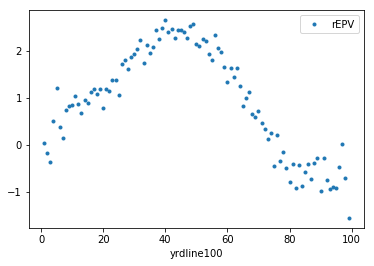

In [13]:
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')

#### Final Values

We can run a simple regression of the raw value on the yard line to produce a "smoothed" estimate of the Expected Possession Value.

After this, `epv_model` contains our model for Expected Possession Value for a location on the field.

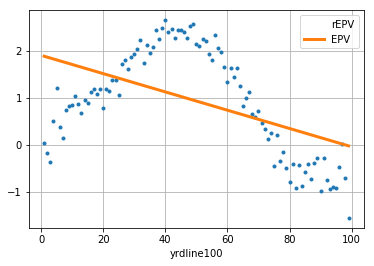

In [14]:
formula = 'rEPV ~ yrdline100'
results = smf.ols(formula, data=possession_values.reset_index()).fit()
# print(results.summary())

possession_values['EPV'] = results.fittedvalues.values
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
possession_values.plot(y='EPV', ax=ax, lw=3)
ax.grid()

epv_model = possession_values['EPV']

### 2.  Expected Conversion Percentage

#### Raw Values

We each separate region on the field (inside the 10 yardline, from the 10 yardline to the 20 yardline, and beyond the 20 yardline), and compute the expected conversion percentage for each yard to go value.  We separate into regions because we have reason to believe that near the goalline, the offense is less likely to convert given less room to work with.  The data bears this out.  This change in conversion percentage can affect the expected value quantities.

In [15]:
# 1. Group by region and yards to go
# 2. Take the average success rate
# 3. Modify the index
conv_pct3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct3.columns = ['rConvPct3']  # update column names
conv_pct3


rConvPct3
yrdregion distance           
Inside10  0          0.944667
          1          0.620063
          2          0.496681
          3          0.437793
          4          0.394673
          5          0.353535
          6          0.327221
          7          0.354735
          8          0.318182
          9          0.315036
10to20    0          0.947945
          1          0.755403
          2          0.596238
          3          0.544109
          4          0.536760
          5          0.458157
          6          0.432910
          7          0.375748
          8          0.376529
          9          0.350946
Beyond20  0          0.951168
          1          0.751015
          2          0.623287
          3          0.556089
          4          0.525126
          5          0.477219
          6          0.440369
          7          0.409013
          8          0.375108
          9          0.357232

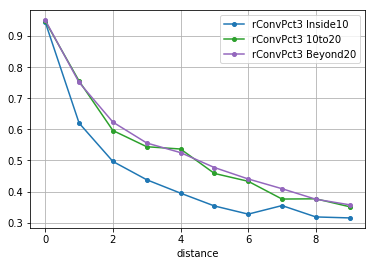

In [16]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C2', '10to20'), ('C4', 'Beyond20')]:
    conv_pct3.loc[region].plot(
        ax=ax, y='rConvPct3', color=color, marker='.', ms=8, label='rConvPct3 ' + region)

ax.legend(loc=1)
ax.grid()

#### Final Values

Unlike for EPV which uses a simple line-fit regression model, we should run a more advanced regression model called LOWESS regression.  In simple terms, it is a curve fit instead of a straight line fit.  We clearly require this since we do not want straight lines for Expected Conversion Percentage.

Our final model for Expected Conversion Percentage will be in `exp_conv_pct_model`.

In [17]:
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region3 = conv_pct3.loc[region]
    conv_pct3.loc[region, 'ExpConvPct3'] = curve_fit(
        conv_pct_region3.index, conv_pct_region3['rConvPct3'])
    
exp_conv_pct_model3 = conv_pct3['ExpConvPct3']

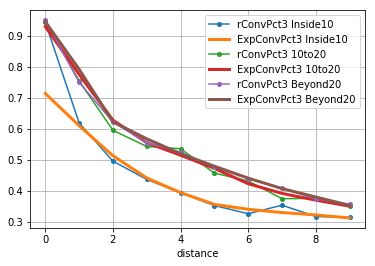

In [18]:
fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'Inside10'), (('C2', 'C3'), '10to20'), (('C4', 'C5'), 'Beyond20')]
for (clr1, clr2), region in it:
    conv_pct3.loc[region].plot(
        ax=ax, y='rConvPct3', color=clr1, marker='.', ms=8, label='rConvPct3 ' + region)
    conv_pct3.loc[region].plot(
        ax=ax, y='ExpConvPct3', color=clr2, lw=3, label='ExpConvPct3 ' + region)

ax.legend(loc=1)
ax.grid()

In [ ]:
###

In [27]:
### 4th down conv
conv_pct4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    mean().\
    to_frame()
conv_pct4.columns = ['rConvPct4']  # update column names
conv_pct4

rConvPct4
yrdregion distance           
Inside10  0          0.563841
          1          0.616794
          2          0.512953
          3          0.460784
          4          0.338028
          5          0.305085
          6          0.420000
          7          0.387097
          8          0.382353
          9          0.250000
10to20    0          0.200000
          1          0.679521
          2          0.562753
          3          0.572254
          4          0.480620
          5          0.404412
          6          0.357895
          7          0.373494
          8          0.352113
          9          0.338462
Beyond20  0          0.597967
          1          0.707969
          2          0.582262
          3          0.522300
          4          0.485610
          5          0.438960
          6          0.428835
          7          0.378125
          8          0.362306
          9          0.387588

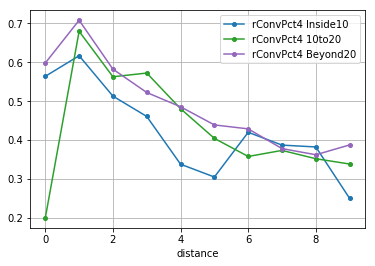

In [28]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C2', '10to20'), ('C4', 'Beyond20')]:
    conv_pct4.loc[region].plot(
        ax=ax, y='rConvPct4', color=color, marker='.', ms=8, label='rConvPct4 ' + region)

ax.legend(loc=1)
ax.grid()

In [29]:
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region4 = conv_pct4.loc[region]
    conv_pct4.loc[region, 'ExpConvPct4'] = curve_fit(
        conv_pct_region4.index, conv_pct_region4['rConvPct4'])
    
exp_conv_pct_model4 = conv_pct4['ExpConvPct4']

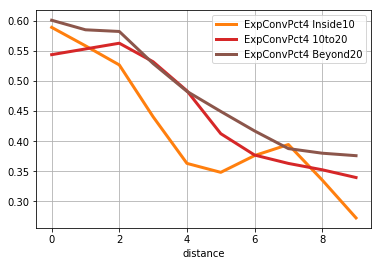

In [31]:
fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'Inside10'), (('C2', 'C3'), '10to20'), (('C4', 'C5'), 'Beyond20')]
for (clr1, clr2), region in it:
    #conv_pct4.loc[region].plot(
        #ax=ax, y='rConvPct4', color=clr1, marker='.', ms=8, label='rConvPct4 ' + region)
    conv_pct4.loc[region].plot(
        ax=ax, y='ExpConvPct4', color=clr2, lw=3, label='ExpConvPct4 ' + region)

ax.legend(loc=1)
ax.grid()

### 3. Net Punt Distance

To compute net punt distance, we consider all the "successful" punts we extracted (ie. ignoring return TDs, muffs, and fumbles, etc).  In building the punts table, we look at the current yardline and the next yardline and computed a difference (accounting for the switch in orientation of the 100 yard value) to get net punt distance.  Now we just need to average.

In [ ]:
# 1. Group by yardline 
# 2. Take the average of net_punt_len (the average automatically ignores null values!)
# 3. Convert to DataFrame instead of Series
# 4. Make the index a column instead
punt_dist = punts.\
    groupby('yrdline100')['net_punt_dist'].\
    mean().\
    to_frame()
punt_dist.columns = ['rExpNetPuntDist']  # Update column names
punt_dist = punt_dist.dropna()
punt_dist

#### Raw Values

In the plot below, we see a beautiful relationship between expected punt distance and the yardline.  As with Expected Possession Value, the expected net punt distance should be increasing as you get closer and not fluctuating as much.

In [ ]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

#### Final Values

We can run our curve fit to generate a final model.  We clearly require this since we do not want a straight line for Expected Net Punt Distance.

`exp_net_punt_dist_model` will contain our model for Expected Net Punt Distance.

In [ ]:
punt_dist['ExpNetPuntDist'] = curve_fit(
    punt_dist.index, punt_dist['rExpNetPuntDist'])

exp_net_punt_dist_model = punt_dist['ExpNetPuntDist']

In [ ]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
punt_dist.plot(y='ExpNetPuntDist', ax=ax, lw=3)
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

In [ ]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
punt_dist.plot(y='ExpNetPuntDist', ax=ax, lw=3)
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

### 4. Expected Field Goal Probability

We gather field goal results and compute the expected probability of success.

In [ ]:
# 1. Group by distance 
# 2. Take the average success rate
# 3. Convert to DataFrame instead of Series
# 4. Make the index a column instead
fg_prob = fgs.\
    groupby('FieldGoalDistance')['FieldGoalSuccess'].\
    mean().\
    to_frame()
fg_prob.columns = ['rFieldGoalProb']  # Update column names
fg_prob

#### Raw Values

Raw Expected Field Goal Probability is a bit noisy as we have grown accustom to seeing so far.  We fit a curve but this time we ignore data observations beyond 63 yards since they are extra noisy.

In [ ]:
ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
ax.legend(loc=0)
ax.grid()

#### Final Values

We can run another curve fit to get a nice estimate of field goal probability.

`exp_fg_prob_model` will contain our field goal probability model.

In [ ]:
under_63_mask = fg_prob.index <= 63.
fg_under_63 = fg_prob.loc[under_63_mask]

fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'] = curve_fit(
    fg_under_63.index, fg_under_63['rFieldGoalProb'])

exp_fg_prob_model = fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'].copy()

ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
fg_prob.plot(y='ExpFieldGoalProb', ax=ax, lw=3)
ax.grid()

### Extracting Model Values

In [ ]:
# Model values can be extracted easily
print("EPV at 60 yards:", epv_model[60])
print("Exp Conv Pct inside the 10 with 1 yard to go: at", exp_conv_pct_model[('Inside10', 1)])
print("Exp Net Punt Dist from the 50:", exp_net_punt_dist_model[50])
print("Exp FG Pct from 45 yards:", exp_fg_prob_model[45])

## V. Decision Maker

## Building the Decision Maker

We pass the model objects into a function which itself then builds a function that evaluates the models and computes the decision.  The steps are:

1. Expected value of going for it
    + Determine the value of a failed conversion
    + Determine the value of a successful conversion
    + Compute the expected value using the conversion success probability
2. Expected value of punting
    + Determine the expected net punt distance
    + Compute the expected value of the expected yardline after the punt
3. Expected value of kicking
    + Compute the value of making the field goal: 3 minus the value of a kickoff
    + Compute the value of missing the field goal.
    + Compute the expected value using the field goal success probability

In [ ]:
epv_model

In [ ]:
def build_decision_maker(ekv, epv_model, exp_conv_pct_model, 
                         exp_net_punt_dist_model, exp_fg_prob_model):
    
    YRDSTOGO_CAP = 10  # Model restriction
    PUNT_LIM = 29      # Model restriction
    FG_LIM = 63        # Model restriction
    FG_OFFSET = 8      # Field goal placement distance (not including the 10 for the endzone)
    FG_FAIL_RESET = 0  # Where the ball is placed after a failed field goal.  If 0, at the spot.  
                       # Otherwise, at the spot or at the reset spot, whichever is better.
    
    def decision_maker(yrdline100, ydstogo, print_message=False):
        if yrdline100 < 10:
            region = 'Inside10'
        elif yrdline100 < 20:
            region = '10to20'
        else:
            region = 'Beyond20'
            
        # 1. Expected value of going for it
        
        # Value of failing (approximately turning over at same spot)
        conv_fail_yrdline100 = 100 - yrdline100
        conv_fail_epv = -epv_model[conv_fail_yrdline100] 
        
        # Value of converting (approximately at the first down marker)
        if yrdline100 == ydstogo:
            conv_succ_epv = 7 - ekv
        else:
            first_down_yrdline100 = yrdline100 - ydstogo
            conv_succ_epv = epv_model[first_down_yrdline100]

        # Conversion Pct
        exp_conv_pct = exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
        
        # Overall expected value of going for it
        go_ev = exp_conv_pct * conv_succ_epv + (1 - exp_conv_pct) * conv_fail_epv
        
        # 2. Expected value of punting
        
        # Expected next yardline
        if yrdline100 >= PUNT_LIM:
            exp_net_punt_dist = exp_net_punt_dist_model[yrdline100]
            exp_yrdline100 = 100 - yrdline100 + int(exp_net_punt_dist)
            
            # Overall expected value of punting
            punt_ev = -epv_model[exp_yrdline100]
        else:
            punt_ev = None
            
        # 3. Expected value of kicking a field goal
        fg_dist =  yrdline100 + 10 + FG_OFFSET
        if fg_dist <= FG_LIM:
            # Probability of success
            exp_fg_prob = exp_fg_prob_model[fg_dist ]

            # Expected value of field success
            fg_succ_epv = 3 - ekv

            # EPV of field goal fail
            fg_fail_yrdline100 = 100 - yrdline100 - FG_OFFSET
            fg_fail_epv = -epv_model[fg_fail_yrdline100]

            # Overall expected value kicking
            fg_ev = fg_succ_epv * exp_fg_prob + fg_fail_epv * (1 - exp_fg_prob)
        else:
            fg_ev = None
    
        choices = [('go for it', go_ev), ('punt', punt_ev), ('kick', fg_ev)]
        max_val = -100
        for choice, ev in choices:
            if ev is None:
                continue
            if ev > max_val:
                max_val = ev
                decision = choice
    
        if print_message:
            print("Expected Values")
            print("Go for it: {:.2f}".format(go_ev))
            if punt_ev is not None:
                print("Punt: {:.2f}".format(punt_ev))
            else:
                print("Punt: TOO CLOSE TO PUNT")
            if fg_ev is not None:
                print("FG: {:.2f}".format(fg_ev))
            else:
                print("FG: TOO FAR TO KICK")        

            print()
            print("Coach, you should:")
            print(decision.upper())

        return decision
    
    return decision_maker

# Build the decision maker
decision_maker = build_decision_maker(
    ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, exp_fg_prob_model)

In [ ]:
# A test
decision_maker(70, 4, print_message=True);

### Compute Decisions

In [ ]:
# Determine the decisions for each combination on the field

yrdlines = list(range(1, 100))
down_dist = list(range(1, 10))

decisions = []
for yrdstogo in down_dist:
    tmp = []
    for yrdline in yrdlines:
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            decision = decision_maker(yrdline, yrdstogo)
            tmp.append(decision)
        else:
            tmp.append(None)
    decisions.append(tmp)
# Convert to a table
pd.DataFrame(decisions, columns=yrdlines, index=down_dist)

### Plot the Decision Rule

In [ ]:
import numpy as np
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = decisions[i][j]
        if decision == 'go for it':
            val = 1
        elif decision == 'punt':
            val = 2
        elif decision == 'kick':
            val = 3
        elif decision is None:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin=1,
    vmax=8,
    edgecolors='k', 
    linewidths=.2,
    cmap=plt.get_cmap('Dark2'),
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['Goal', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([
    yd - .5
    for yd in range(1, 10)
])
ax.set_yticklabels([
    '4th and {}'.format(yd)
    for yd in range(9, 0, -1)
])
ax.text(50, 6, 'Go for it', size=25)
ax.text(20, 1.5, 'Punt', size=25)
ax.text(75, 1.5, 'Kick', size=25)
ax.tick_params(axis='both', which='major', labelsize=15);